In [1]:
# todo: check the model cfg: augmentations, policy

In [1]:
from tqdm import tqdm
import numpy as np
import cv2
from matplotlib import pyplot as plt

import torch
from torch import nn
from utils import parse_cfg, iou_vectorized, objectness_filter_and_nms, show_predictions, scale_numbers, letterbox_pad
from darknet import Darknet

In [2]:
darknet = Darknet('cfg/yolov3_test_todel.cfg')
weight_file = 'weights/yolov3.weights'
darknet.load_weights(weight_file)
darknet.eval();


we also can remove bias due to bn
make_layers returns net_info as well. check whether it"s necessary
shortcut is using output[i-1] instead of x check whether works with x
NOTE THAT CONV BEFORE YOLO USES (num_classes filters) * num_anch
changing predictions in the nms loop make sure that it is not used later
not adding +1 in nms


(452, 602, 3)


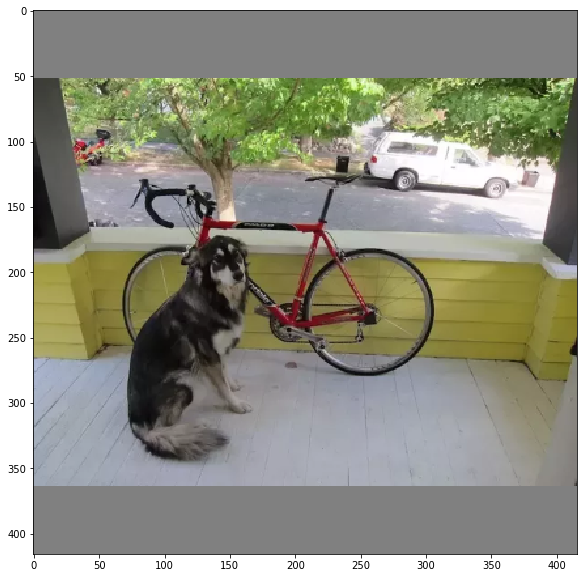

/miniconda3/envs/main/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/miniconda3/envs/main/lib/python3.5/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


make bboxes on image more pleasant


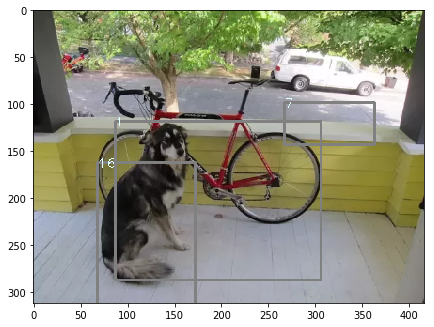

In [7]:
classes = 80
net_input_size = int(darknet.net_info['width'])
device = torch.device('cpu:0')

plt.figure(figsize=(10, 10))
img_path = 'dog-cycle-car.png'
# img_path = 'people_outside.jpg'
# img_path = 'city_hall.jpg'
img = cv2.imread(img_path)
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
H, W, C = img.shape
H_new, W_new = scale_numbers(H, W, net_input_size)
img = cv2.resize(img, (W_new, H_new))
img, _ = letterbox_pad(img, net_input_size, color=(128, 128, 128))
plt.imshow(img)
plt.show()
img = img.transpose((2, 0, 1))
img = torch.from_numpy(img).float()
img = img.unsqueeze(0)
img = img / 255
pred = darknet(img, device)
pred = objectness_filter_and_nms(pred, classes)
show_predictions('dog-cycle-car.png', pred, classes, net_input_size)

In [ ]:
# todo show_predictions(): a) bboxes shift and aspect ratio (coeff); b) bboxes colors and labels